In [1]:
import pandas as pd
from dateutil.relativedelta import relativedelta
import numpy as np
import re
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import warnings
warnings.filterwarnings("ignore")
import math
import os
from datetime import date, timedelta, datetime
import time
from tqdm import tqdm
import seaborn as sns
from scipy import stats
import xlsxwriter
from matplotlib.ticker import MaxNLocator
from matplotlib.backends.backend_pdf import PdfPages
start_time = time.perf_counter()

In [2]:
mapping = pd.read_excel("company_master_mapping.xlsx")
# price_data = d.fetch_price_data(no_of_years=20)
price_data = pd.read_csv('stockPriceData-3.csv')
# Convert 'Date' to datetime type
price_data['Date'] = pd.to_datetime(price_data['Date'])

# Create a dictionary mapping from SYMBOL_NSE to SYMBOL_CM
mapping = dict(zip(mapping["SYMBOL_NSE"], mapping["SYMBOL_CM"]))
price_data["Symbol"] = price_data["Symbol"].replace(mapping)

top_500 =  price_data.groupby('Date', group_keys= False).apply(lambda x: x.sort_values(by='Mcap', ascending=False).head(500))
# Filter price data for dates after '2006-01-01' and drop duplicates
price_data.drop_duplicates(['Date', 'Symbol'], inplace=True)

#company master swapping
# company_master = d.fetch_data_from_database(table_name='Companymaster')
company_master = pd.read_csv('Companymaster_3_2_2025.csv')
company_master["SYMBOL"] = company_master["SYMBOL"].replace(mapping)

yearly = pd.read_csv('Finance_pl_3_2_2025.csv')
Quaterly = pd.read_csv('Quarterly_3_2_2025.csv')
Finance_bs =  pd.read_csv('Finance_bs_3_2_2025.csv')[[ 'Year_end', 'Fincode', 'Share_Capital', 'Reserve']]

rebal_dates = pd.read_csv('GrowthDate.csv')

rebal_dates["Date"] = pd.to_datetime(rebal_dates["Date"])
rebal=rebal_dates['Date']

Rebalance_Qtr=list(rebal_dates['Quarter'])
Rebalance_Date=list(rebal_dates['Date'])
Qtr_date_dict=dict(zip(Rebalance_Date,Rebalance_Qtr))
date_Qtr_dict=dict(zip(Rebalance_Qtr,Rebalance_Date))
top_500['Quarter']=top_500['Date'].map(Qtr_date_dict)
index_constituents_data= top_500

X = Quaterly[Quaterly['Result_Type'] == 'Q']
print(X.columns)

work = X[['Date_End', 'Fincode', 'Adj_eps_abs']]
final = pd.merge(work, company_master[['FINCODE', 'SYMBOL']], left_on='Fincode', right_on='FINCODE')
a = final[['Fincode', 'Date_End', 'SYMBOL', 'Adj_eps_abs']].reset_index(drop=True)

a = a[a.SYMBOL.notna()]

# Filtering Stocks which have been historically in top 500 universe only.
b = a[a.SYMBOL.isin(top_500.Symbol.unique())]

# Filter out stocks with fewer than 4 quarters of history
symbol_quarter_counts = b.groupby('SYMBOL').size()
valid_symbols = symbol_quarter_counts[symbol_quarter_counts >= 4].index
b = b[b['SYMBOL'].isin(valid_symbols)]

# Calculate Adjusted EPS TTM
b['Adj_eps_abs_TTM'] = b.groupby('SYMBOL')['Adj_eps_abs'].transform(lambda x: x.rolling(4).sum())
b

Index(['Fincode', 'Result_Type', 'NoOfMonths', 'Date_End', 'NET_SALES',
       'INT_ADV', 'INC_INV', 'INT_BAL', 'INT_OTHERS', 'OTHER_INCOME',
       ...
       'exc_foreign_exch_gain', 'exc_other', 'Curr_tax', 'Def_tax',
       'Fringe_benefits', 'Prior_Period_Tax', 'Mat_Credit', 'Other_Tax',
       'flag', 'notes'],
      dtype='object', length=132)


,Fincode,Date_End,SYMBOL,Adj_eps_abs,Adj_eps_abs_TTM
0,100002,200003,ABB,0.0348,NaN
1,100002,200006,ABB,0.1048,NaN
2,100002,200009,ABB,0.1292,NaN
3,100002,200012,ABB,0.2807,0.5495
4,100002,200103,ABB,0.0456,0.5603
...,...,...,...,...,...
333405,311742,202409,DOMS,7.9185,28.8815
333445,312314,202312,AZAD,2.8426,NaN
333446,312314,202403,AZAD,2.5254,NaN
333447,312314,202406,AZAD,2.8977,NaN


In [3]:
# 2) Create lagged EPS columns for each SYMBOL
#    We'll need at least 4 lags (t−1, t−2, t−3, t−4) for QoQ, YoY, acceleration, and slope
b['EPS_lag1'] = b.groupby('SYMBOL')['Adj_eps_abs'].shift(1)
b['EPS_lag2'] = b.groupby('SYMBOL')['Adj_eps_abs'].shift(2)
b['EPS_lag3'] = b.groupby('SYMBOL')['Adj_eps_abs'].shift(3)
b['EPS_lag4'] = b.groupby('SYMBOL')['Adj_eps_abs'].shift(4)

# 3) Compute QoQ (quarter-over-quarter) EPS growth:
#      (EPS_t − EPS_{t−1}) / |EPS_{t−1}|
b['QoQ_Growth'] = (b['Adj_eps_abs'] - b['EPS_lag1']) / b['EPS_lag1'].abs()

# 4) Compute YoY (year-over-year) EPS growth:
#      (EPS_t − EPS_{t−4}) / |EPS_{t−4}|
b['YoY_Growth'] = (b['Adj_eps_abs'] - b['EPS_lag4']) / b['EPS_lag4'].abs()

# 5) Compute “Earnings Acceleration” = QoQ_t − QoQ_{t−1}
#    First get QoQ_{t−1}, i.e. shift QoQ_Growth by one more period
b['QoQ_lag1'] = b.groupby('SYMBOL')['QoQ_Growth'].shift(1)
b['Earnings_Accel'] = b['QoQ_Growth'] - b['QoQ_lag1']

# 6) Compute a 4‐quarter linear slope of EPS for each SYMBOL
def slope_last_4(eps_vals):
    """
    Given a sequence of exactly 4 EPS values [EPS_{t−3}, EPS_{t−2}, EPS_{t−1}, EPS_t],
    return the OLS slope coefficient from regressing EPS on time index [0,1,2,3].
    If any value is NaN, return NaN.
    """
    y = np.array(eps_vals, dtype=float)
    if np.isnan(y).any():
        return np.nan
    x = np.arange(4, dtype=float)
    x_mean, y_mean = x.mean(), y.mean()
    num = ((x - x_mean) * (y - y_mean)).sum()
    den = ((x - x_mean) ** 2).sum()
    return num / den if den != 0 else np.nan  # Added the missing return statement

# Method 1: Using apply with axis=1 (Recommended)
b['EPS_Slope_4Q'] = b[['EPS_lag3', 'EPS_lag2', 'EPS_lag1', 'Adj_eps_abs']].apply(
    lambda row: slope_last_4(row.values), axis=1
)

# 7) Compute volatility‐adjusted QoQ: divide QoQ_Growth by rolling std of QoQ over last 8 quarters
#    First, build an 8‐quarter rolling std of QoQ_Growth for each SYMBOL
b['Std_QoQ_8Q'] = b.groupby('SYMBOL')['QoQ_Growth'] \
    .transform(lambda x: x.rolling(window=8).std())

# Then volatility‐adjusted QoQ:
b['VolAdj_QoQ'] = b['QoQ_Growth'] / b['Std_QoQ_8Q']
# Replace infinite or NaN from division by zero with zero
b['VolAdj_QoQ'] = b['VolAdj_QoQ'].replace([np.inf, -np.inf], np.nan).fillna(0)

# 8) Compute “EPS Surprise” vs. a 4‐quarter rolling mean:
#    EPS_Roll4Avg_t = average of EPS_{t−1}, EPS_{t−2}, EPS_{t−3}, EPS_{t−4}
b['EPS_Roll4Avg'] = b.groupby('SYMBOL')['Adj_eps_abs'] \
    .transform(lambda x: x.shift(1).rolling(window=4).mean())

# List all of the “final” metrics you want to z‐score:
metrics = [
    'QoQ_Growth',
    'YoY_Growth',
    'Earnings_Accel',
    'EPS_Slope_4Q',
    'VolAdj_QoQ'
]

# For each metric, compute its cross‐sectional z‐score by Date_End
for col in metrics:
    z_col = f'{col}_Z'
    b[z_col] = b.groupby('Date_End')[col] \
               .transform(lambda x: (x - x.mean()) / x.std()) \
               .fillna(0)



# Then Surprise = EPS_t − EPS_Roll4Avg_t
b['EPS_Surprise'] = b['Adj_eps_abs'] - b['EPS_Roll4Avg']

# Standardize Surprise within each Date_End (cross‐sectional z‐score)
b['Mean_Surprise'] = b.groupby('Date_End')['EPS_Surprise'].transform('mean')
b['Std_Surprise']  = b.groupby('Date_End')['EPS_Surprise'].transform('std')
b['EPS_Surprise_Z'] = (b['EPS_Surprise'] - b['Mean_Surprise']) / b['Std_Surprise']
b['EPS_Surprise_Z'] = b['EPS_Surprise_Z'].fillna(0)

In [4]:
b = b.dropna()
b

,Fincode,Date_End,SYMBOL,Adj_eps_abs,Adj_eps_abs_TTM,EPS_lag1,EPS_lag2,EPS_lag3,EPS_lag4,QoQ_Growth,...,EPS_Roll4Avg,QoQ_Growth_Z,YoY_Growth_Z,Earnings_Accel_Z,EPS_Slope_4Q_Z,VolAdj_QoQ_Z,EPS_Surprise,Mean_Surprise,Std_Surprise,EPS_Surprise_Z
8,100002,200203,ABB,0.0586,1.7444,1.4501,0.1422,0.0935,0.0456,-0.959589,...,0.432850,-0.172907,0.000000,0.000000,0.024172,-0.623973,-0.374250,0.345787,2.605320,-0.276372
9,100002,200206,ABB,0.8555,2.5064,0.0586,1.4501,0.1422,0.0935,13.598976,...,0.436100,5.913872,0.000000,0.718430,0.022973,3.357636,0.419400,0.070140,3.857305,0.090545
10,100002,200209,ABB,0.1636,2.5278,0.8555,0.0586,1.4501,0.1422,-0.808767,...,0.626600,0.000000,0.000000,0.000000,0.069551,-0.536632,-0.463000,-599.971625,8532.084842,0.070265
11,100002,200212,ABB,0.3746,1.4523,0.1636,0.8555,0.0586,1.4501,1.289731,...,0.631950,0.052670,0.000000,0.000000,0.066207,0.285809,-0.257350,-707.230808,10611.772876,0.066622
12,100002,200303,ABB,0.0826,1.4763,0.3746,0.1636,0.8555,0.0586,-0.779498,...,0.363075,0.000000,-0.043216,-0.165192,0.066323,-0.479984,-0.280475,209.026006,3152.248007,-0.066399
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
332907,305013,202409,MSUMI,0.3440,1.4934,0.3367,0.4330,0.3797,0.3526,0.021681,...,0.375500,0.032547,-0.082325,0.000000,0.027562,-0.068375,-0.031500,-1.761411,58.828227,0.029406
332953,305653,202403,GMRP&UI,6.1150,10.6860,5.1070,-0.0999,-0.4361,-5.9089,0.197376,...,-0.334475,0.000000,0.060238,0.000000,0.030673,-0.215764,6.449475,-72.213681,2445.989149,0.032160
332954,305653,202406,GMRP&UI,-3.3829,7.7392,6.1150,5.1070,-0.0999,-0.4361,-1.553213,...,2.671500,0.000000,-0.187083,0.000000,0.015420,-0.153153,-6.054400,-60.166206,2140.555535,0.025279
332955,305653,202409,GMRP&UI,10.9423,18.7814,-3.3829,6.1150,5.1070,-0.0999,4.234592,...,1.934800,0.047289,6.834537,0.000000,0.046997,0.046084,9.007500,-1.761411,58.828227,0.183057


In [5]:
newdf = b[['Fincode','Date_End','SYMBOL','YoY_Growth_Z','Earnings_Accel_Z','EPS_Slope_4Q_Z','VolAdj_QoQ_Z','EPS_Surprise_Z']]
# List your Z-score columns
z_columns = ['YoY_Growth_Z', 'Earnings_Accel_Z', 'EPS_Slope_4Q_Z', 'VolAdj_QoQ_Z', 'EPS_Surprise_Z']

# Calculate the average across those columns
newdf['Avg_Z'] = newdf[z_columns].mean(axis=1)
newdf

,Fincode,Date_End,SYMBOL,YoY_Growth_Z,Earnings_Accel_Z,EPS_Slope_4Q_Z,VolAdj_QoQ_Z,EPS_Surprise_Z,Avg_Z
8,100002,200203,ABB,0.000000,0.000000,0.024172,-0.623973,-0.276372,-0.175235
9,100002,200206,ABB,0.000000,0.718430,0.022973,3.357636,0.090545,0.837917
10,100002,200209,ABB,0.000000,0.000000,0.069551,-0.536632,0.070265,-0.079363
11,100002,200212,ABB,0.000000,0.000000,0.066207,0.285809,0.066622,0.083728
12,100002,200303,ABB,-0.043216,-0.165192,0.066323,-0.479984,-0.066399,-0.137694
...,...,...,...,...,...,...,...,...,...
332907,305013,202409,MSUMI,-0.082325,0.000000,0.027562,-0.068375,0.029406,-0.018746
332953,305653,202403,GMRP&UI,0.060238,0.000000,0.030673,-0.215764,0.032160,-0.018539
332954,305653,202406,GMRP&UI,-0.187083,0.000000,0.015420,-0.153153,0.025279,-0.059907
332955,305653,202409,GMRP&UI,6.834537,0.000000,0.046997,0.046084,0.183057,1.422135


In [6]:
newdf.rename(columns={'SYMBOL' : 'Symbol'}, inplace=True)

In [7]:
GrowthDate = pd.read_csv('GrowthDate.csv')[['Date', 'Qtr']]
GrowthDate['Qtr'] = GrowthDate['Qtr'].astype('int')
# GrowthDate Mapping  
final_df =  pd.merge(newdf, GrowthDate, left_on='Date_End', right_on='Qtr').drop(columns=['Date_End', 'Qtr'])
final_df = final_df[['Date', 'Symbol', 'Avg_Z']].sort_values(by='Date').reset_index(drop=True)
final_df

,Date,Symbol,Avg_Z
0,2006-05-31,ABB,-0.330533
1,2006-05-31,SINTEX,0.282041
2,2006-05-31,FORBESGOK,0.107610
3,2006-05-31,KESORAMIND,0.612821
4,2006-05-31,VTL,0.299712
...,...,...,...
79995,2024-11-18,POWERGRID,-0.049891
79996,2024-11-18,RUBYMILLS,-0.354950
79997,2024-11-18,PHOENIXLTD,0.079749
79998,2024-11-18,PASUPATSPG,0.012283


In [8]:
# Merging Quality Ranks with price data universe
price_data['Date'] = pd.to_datetime(price_data['Date'])
final_df['Date'] = pd.to_datetime(final_df['Date'])
merged_df = pd.merge(final_df[['Date', 'Symbol', 'Avg_Z']], price_data, on=['Date', 'Symbol'], how='outer')
merged_df =  merged_df.groupby('Date', group_keys= False).apply(lambda x: x.sort_values(by='Mcap', ascending=False).head(500))
merged_df['EarningsMom_pct_rank'] = merged_df.groupby('Date', group_keys=False)['Avg_Z'].apply(lambda x : x.rank(pct=True))

In [9]:
merged_df[['EarningsMom_pct_rank']] = merged_df.groupby('Symbol', group_keys=False)[['EarningsMom_pct_rank']].apply(lambda x: x.fillna(method='ffill'))
qualityfinal = merged_df[['Date','Symbol','EarningsMom_pct_rank']]
qualityfinal

,Date,Symbol,EarningsMom_pct_rank
7,1995-05-08,RELIANCE,NaN
9,1995-05-08,TATASTEEL,NaN
5,1995-05-08,HINDPETRO,NaN
3,1995-05-08,GRASIM,NaN
1,1995-05-08,BPCL,NaN
...,...,...,...
7497596,2025-05-06,INDIACEM,0.026201
7498422,2025-05-06,SAFARI,0.045852
7496856,2025-05-06,ARVIND,0.133333
7497711,2025-05-06,JMFINANCIL,0.975983


In [10]:
top500 = qualityfinal.filter(["Symbol", "Date","EarningsMom_pct_rank"])

## Convert the long from Dataframe to wide form dataframe
top500 = top500.pivot_table(index='Date',columns='Symbol',values='EarningsMom_pct_rank').reset_index()
## Shifting the Date column
top500["Date"] = top500["Date"].shift(-1)
## Fill NaN value of date with todays date.
top500.iloc[-1, top500.columns.get_loc("Date")] = pd.to_datetime(date.today())

## Re-converting the wide form dataframe to long form dataframe
top500 = top500.melt(id_vars='Date', value_name = "EarningsMom_pct_rank")
## Drop na and reset the index
top500 = top500.dropna().reset_index(drop = True)
top500 = top500[top500["Date"] >= "2006-01-01"].reset_index(drop = True).copy()
top500

,Date,Symbol,EarningsMom_pct_rank
0,2021-08-17,360ONE,0.296214
1,2021-08-18,360ONE,0.296214
2,2021-08-20,360ONE,0.296214
3,2021-08-23,360ONE,0.296214
4,2021-08-24,360ONE,0.296214
...,...,...,...
2083366,2025-04-30,ZYDUSWELL,0.668122
2083367,2025-05-02,ZYDUSWELL,0.668122
2083368,2025-05-05,ZYDUSWELL,0.668122
2083369,2025-05-06,ZYDUSWELL,0.668122


In [11]:
price_data = pd.read_csv('stockPriceData-3.csv')
# etf_indices = pd.read_csv('.csv')
# price_data = price_data[~(price_data['Symbol'].isin(etf_indices['Symbol']))]
price_data_500 = price_data.groupby('Date', group_keys=False).apply(lambda x: x.sort_values(by='Mcap', ascending=False).head(500))
df = price_data[price_data['Symbol'].isin(price_data_500['Symbol'])]
df['Date'] = pd.to_datetime(df['Date'])
master_date = df.drop_duplicates(subset='Date')[['Date']].reset_index(drop=True)
df.set_index('Date', inplace=True)

df = df.sort_values(by=['Date','Mcap'], ascending=[True,False])
df = df.sort_values(['Symbol', 'Date'])
df['PrevClose'] = df.groupby('Symbol')['Close'].shift(1)
df['returns'] = (df['Close'] - df['PrevClose']) / df['PrevClose']


In [13]:
top_25 = (
    top500[['Date', 'Symbol', 'EarningsMom_pct_rank']]
      .sort_values(['Date', 'EarningsMom_pct_rank'], ascending=[True, False])
      .groupby('Date')
      .head(50)
      .reset_index(drop=True)
)
top_25

,Date,Symbol,EarningsMom_pct_rank
0,2006-06-01,IOC,1.000000
1,2006-06-01,INDIACEM,0.995392
2,2006-06-01,SRF,0.990783
3,2006-06-01,MASTEK,0.986175
4,2006-06-01,GEOMETRIC,0.981567
...,...,...,...
233545,2025-06-02,POLYMED,0.897380
233546,2025-06-02,COROMANDEL,0.895197
233547,2025-06-02,CAPLIPOINT,0.893013
233548,2025-06-02,ICICIBANK,0.890830


In [15]:
# Define the start date (it should start from 2006-06-19)
start_date = pd.to_datetime('2006-06-19')

# Filter the dates starting from 2006-06-19 (this ensures the start date is included)
filtered_dates = master_date[master_date['Date'] >= start_date]

# Ensure the start date is included
start_date_row = filtered_dates[filtered_dates['Date'] == start_date]

# Select every 50th date from the filtered dates (starting from the filtered list after the start date)
selected_dates = filtered_dates.iloc[::60]

# Combine the start date with the selected dates
selected_dates = pd.concat([start_date_row, selected_dates])

# Drop any NaN values and sort by date to ensure it's in the correct order
selected_dates = selected_dates.dropna().sort_values(by='Date')

combined_dates_portfolio = top_25[top_25['Date'].isin(selected_dates['Date'])]
combined_dates_portfolio

,Date,Symbol,EarningsMom_pct_rank
600,2006-06-19,IOC,1.000000
601,2006-06-19,INDIACEM,0.995392
602,2006-06-19,SRF,0.990783
603,2006-06-19,MASTEK,0.986175
604,2006-06-19,GEOMETRIC,0.981567
...,...,...,...
233195,2025-04-25,TRITURBINE,0.899563
233196,2025-04-25,POLYMED,0.897380
233197,2025-04-25,COROMANDEL,0.895197
233198,2025-04-25,CAPLIPOINT,0.893013


In [16]:
master_date = master_date.sort_values(by='Date')
portfolio = combined_dates_portfolio.groupby("Date")["Symbol"].apply(list).reset_index()

# Expand portfolio by date
merged = pd.merge_asof(master_date, portfolio, on="Date")

merged = merged.explode("Symbol").dropna(subset=["Symbol"])
merged = merged[merged["Date"]>= '2006-06-19'].reset_index(drop=True)
merged

,Date,Symbol
0,2006-06-19,IOC
1,2006-06-19,INDIACEM
2,2006-06-19,SRF
3,2006-06-19,MASTEK
4,2006-06-19,GEOMETRIC
...,...,...
232895,2025-05-06,TRITURBINE
232896,2025-05-06,POLYMED
232897,2025-05-06,COROMANDEL
232898,2025-05-06,CAPLIPOINT


In [17]:
# Make sure 'Date' is a column, not index
df_reset = df.reset_index()

# Merge with returns
merged = pd.merge(merged, df_reset[["Date", "Symbol", "returns"]], on=["Date", "Symbol"], how="left")

# Compute NAV (average return across stocks each date)
nav = merged.groupby("Date")["returns"].mean()

# Apply rebalance cost on rebalance dates
rebalance_dates = pd.to_datetime(selected_dates['Date']).tolist()
nav.loc[nav.index.isin(rebalance_dates)] -= 0.01

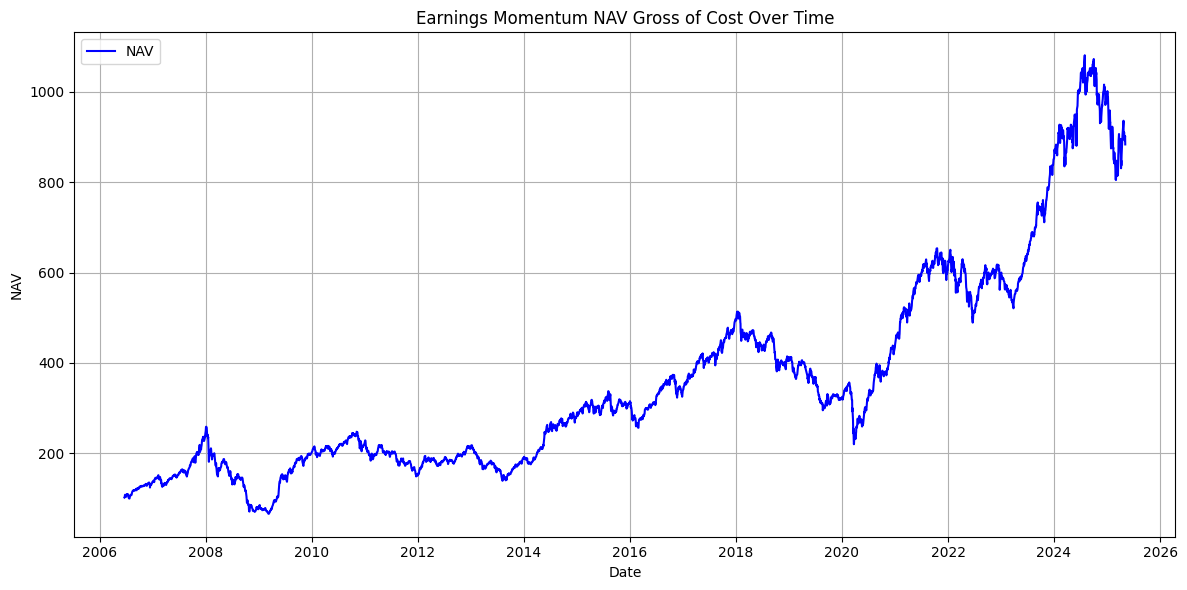

In [18]:
# Step 1: Compute NAV
nav = (1 + nav).cumprod() * 100

# Step 2: Plot NAV
plt.figure(figsize=(12, 6))
plt.plot(nav.index, nav.values, label='NAV', color='blue')
plt.title('Earnings Momentum NAV Gross of Cost Over Time')
plt.xlabel('Date')
plt.ylabel('NAV')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [19]:
# Ensure NAV is sorted
nav = nav.sort_index()
daily_returns = nav.pct_change().dropna()

# Compute overall metrics
start_date = nav.index[0]
end_date = nav.index[-1]
days = (end_date - start_date).days
years = days / 365.25

cagr = (nav.iloc[-1] / nav.iloc[0])**(1 / years) - 1
rolling_max = nav.cummax()
drawdown = nav / rolling_max - 1
mdd = drawdown.min()
volatility = daily_returns.std() * np.sqrt(252)
# Calendar Year Returns
cy_returns = nav.resample('Y').last().pct_change().dropna()
cy_returns.index = cy_returns.index.year
cy_df = pd.DataFrame({'CY Return': cy_returns})

# Financial Year Returns (Apr–Mar)
fy_nav = nav.copy()
fy_nav.index = fy_nav.index.to_period('M')
fy_ends = fy_nav.groupby(fy_nav.index.to_timestamp().to_period("A-MAR")).last()
fy_returns = fy_ends.pct_change().dropna()
fy_returns.index = fy_returns.index.year + 1
fy_df = pd.DataFrame({'FY Return': fy_returns})

# Monthly returns
monthly_periods = {
    '1M Return': 21,
    '2M Return': 42,
    '3M Return': 63,
    '6M Return': 126,
    '12M Return': 252,
    '24M Return': 504
}

monthly_data = []
for label, days_back in monthly_periods.items():
    if len(nav) > days_back:
        ret = nav.iloc[-1] / nav.iloc[-days_back] - 1
        monthly_data.append({'Metric': label, 'Value': ret, 'Period': 'Latest'})

# Summary Metrics
summary_df = pd.DataFrame({
    'Metric': ['CAGR', 'Max Drawdown', 'Annualized Volatility'],
    'Value': [cagr, mdd, volatility],
    'Period': 'Overall'
})

# Calendar Year
cy_df_formatted = cy_df.rename_axis('Year').reset_index()
cy_df_formatted['Metric'] = 'CY Return'
cy_df_formatted = cy_df_formatted.rename(columns={'Year': 'Period', 'CY Return': 'Value'})

# Financial Year
fy_df_formatted = fy_df.rename_axis('Year').reset_index()
fy_df_formatted['Metric'] = 'FY Return'
fy_df_formatted = fy_df_formatted.rename(columns={'Year': 'Period', 'FY Return': 'Value'})

# Combine all
final_df = pd.concat([
    summary_df,
    pd.DataFrame(monthly_data),
    cy_df_formatted[['Metric', 'Period', 'Value']],
    fy_df_formatted[['Metric', 'Period', 'Value']]
], ignore_index=True)

# Optional: format as percentage
final_df['Value'] = final_df['Value'].apply(lambda x: f"{x:.2%}")

# Display
print(final_df)

                   Metric    Value   Period
0                    CAGR   12.12%  Overall
1            Max Drawdown  -74.46%  Overall
2   Annualized Volatility   21.46%  Overall
3               1M Return   -0.74%   Latest
4               2M Return    9.52%   Latest
5               3M Return   -1.31%   Latest
6               6M Return   -9.54%   Latest
7              12M Return   -4.71%   Latest
8              24M Return   57.06%   Latest
9               CY Return   82.08%     2007
10              CY Return  -68.20%     2008
11              CY Return  155.77%     2009
12              CY Return   11.01%     2010
13              CY Return  -33.01%     2011
14              CY Return   40.86%     2012
15              CY Return  -10.41%     2013
16              CY Return   50.21%     2014
17              CY Return    9.56%     2015
18              CY Return    7.93%     2016
19              CY Return   47.28%     2017
20              CY Return  -17.32%     2018
21              CY Return  -21.7

In [76]:
final_df

,Metric,Value,Period
0,CAGR,17.87%,Overall
1,Max Drawdown,-71.34%,Overall
2,Annualized Volatility,21.38%,Overall
3,1M Return,-1.59%,Latest
4,2M Return,8.91%,Latest
5,3M Return,-0.41%,Latest
6,6M Return,-6.67%,Latest
7,12M Return,6.79%,Latest
8,24M Return,71.54%,Latest
9,CY Return,87.95%,2007


In [20]:
combined_dates_portfolio.drop(columns=['EarningsMom_pct_rank']).tail(25)

,Date,Symbol
233175,2025-04-25,ASTRAZEN
233176,2025-04-25,REDINGTON
233177,2025-04-25,RAINBOW
233178,2025-04-25,APTUS
233179,2025-04-25,APOLLOHOSP
233180,2025-04-25,MOTHERSON
233181,2025-04-25,BAJAJHLDNG
233182,2025-04-25,PTCIL
233183,2025-04-25,BANKINDIA
233184,2025-04-25,OLECTRA


In [ ]:
# Assuming nav is a pandas Series with Date as index
nav_df = nav.to_frame(name='NAV')
nav_df

,NAV
Date,
2006-06-19,101.953788
2006-06-20,102.223132
2006-06-21,104.555652
2006-06-22,107.499904
2006-06-23,108.182659
...,...
2025-04-29,909.390412
2025-04-30,894.413942
2025-05-02,892.197735


In [22]:
nav_df.rename(columns={'NAV' : 'EarningsMom'}, inplace=True)
nav_df.to_csv('EarningsMom.csv')

In [11]:
x = top500[['Date', 'Symbol', 'EarningsMom_pct_rank']]
x = x.sort_values(['Date', 'EarningsMom_pct_rank'], ascending=[True, False])
x

,Date,Symbol,EarningsMom_pct_rank
984307,2006-06-01,IOC,1.000000
941545,2006-06-01,INDIACEM,0.995392
1740605,2006-06-01,SRF,0.990783
1254529,2006-06-01,MASTEK,0.986175
670412,2006-06-01,GEOMETRIC,0.981567
...,...,...,...
960505,2025-06-03,INDUSINDBK,0.010917
27806,2025-06-03,ABFRL,0.008734
934499,2025-06-03,IIFL,0.006550
1683516,2025-06-03,SHREECEM,0.004367


In [14]:
x.to_csv('E_Mom_Rank.csv', index=False)